# Using `gwent` to Generate Source Characteristic Strain Curves

Here we show examples of using the different classes in `gwent` for various black holes binaries (BHBs), both in the frequency and time domain.

First, we load important packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os,sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.legend_handler import HandlerNpoints, HandlerTuple

from scipy.constants import golden_ratio

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo

import gwent
import gwent.detector as detector
import gwent.binary as binary
import gwent.snr as snr

Setting matplotlib and plotting preferences

In [3]:
def get_fig_size(width=7,scale=1.0):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles'

## Initialize different instruments

To compare BHB strains and assess their detectability, we load in a few example detectors. For more information about loading instruments, see the tutorial on detectors.


### NANOGrav 11yr Characteristic Strain

Using real NANOGrav 11yr data put through `hasasia`

In [5]:
NANOGrav_filedirectory = load_directory + '/InstrumentFiles/NANOGrav/StrainFiles/' 
NANOGrav_11yr_hasasia_file = NANOGrav_filedirectory + 'NANOGrav_11yr_S_eff.txt'
NANOGrav_11yr_hasasia = detector.PTA('NANOGrav 11yr',load_location=NANOGrav_11yr_hasasia_file,I_type='E')
NANOGrav_11yr_hasasia.T_obs = 11.4*u.yr

### LISA Proposal 1

Values taken from the ESA L3 proposal, Amaro-Seaone, et al., 2017 (https://arxiv.org/abs/1702.00786)

In [6]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr

f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

LISA_prop1 = detector.SpaceBased('LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)

### aLIGO

In [7]:
Ground_T_obs = 4*u.yr
#aLIGO
aLIGO_filedirectory = load_directory + '/InstrumentFiles/aLIGO/'
aLIGO_1_filename = 'aLIGODesign.txt'

aLIGO_1_filelocation = aLIGO_filedirectory + aLIGO_1_filename

aLIGO_1 = detector.GroundBased('aLIGO 1',Ground_T_obs,load_location=aLIGO_1_filelocation,I_type='A')

## Generating Binary Black Holes with `gwent` in the Frequency Domain

We start with BHB parameters that exemplify the range of IMRPhenomD's waveforms from Khan, et al. 2016 https://arxiv.org/abs/1508.07253 and Husa, et al. 2016 https://arxiv.org/abs/1508.07250 

In [8]:
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]

Uses the first parameter values and the `LISA_prop1` detector model for calculation of the monochromatic strain.

In [9]:
source_1 = binary.BBHFrequencyDomain(M[0],q[0],z[0],x1[0],x2[0])

Uses the first parameter values and the `aLIGO` detector model for calculation of the monochromatic strain.

In [10]:
source_2 = binary.BBHFrequencyDomain(M[1],q[1],z[1],x1[1],x2[1])

Uses the first parameter values and the `NANOGrav_11yr_hasasia` detector model for calculation of the monochromatic strain.

In [11]:
source_3 = binary.BBHFrequencyDomain(M[2],q[2],z[2],x1[2],x2[2],instrument=NANOGrav_11yr_hasasia)

## How to Get Information about BHB

### Find out source 1's frequency given some time from merger.

In [12]:
print("Source frequency 10 years prior to merger in Observer frame: ",
      source_1.Get_Source_Freq(10*u.yr,frame='observer'))
print("Source frequency 10 years prior to merger in Source frame: ",
      source_1.Get_Source_Freq(10*u.yr,frame='source'))

Source frequency 10 years prior to merger in Observer frame:  4.9371229709723884e-05 1 / s
Source frequency 10 years prior to merger in Source frame:  2.9356308823618684e-05 1 / s


### Find out source 2's time to merger from a given frequency.

In [13]:
print("Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Observer frame: ",
      source_2.Get_Time_From_Merger(1/u.minute,frame='observer').to('yr'))
print("Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Source frame: ",
      source_2.Get_Time_From_Merger(1/u.minute,frame='source').to('yr'))

Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Observer frame:  17.032270309184458 yr
Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Source frame:  21.59034784914432 yr


### Find out source 3's observed frequency given some evolved time. 
And whether the source is monochromatic or chirping for the evolved time in the observer frame.

In [14]:
source_3.Check_Freq_Evol(T_evol=5*u.yr,T_evol_frame='observer')
print("Observed frequency after 5 years of evolution in Observer frame: ",
      source_3.f_T_obs)
print("Does the source change a resolvable amount after evolving for 5 years in the Observer frame?: ",
      source_3.ismono)
print("\n")
source_3.Check_Freq_Evol(T_evol=5*u.yr,T_evol_frame='source')
print("Observed frequency after 5 years of evolution in Source frame: ",
      source_3.f_T_obs)
print("Does the source change a resolvable amount after evolving for 5 years in the Source frame?: ",
      source_3.ismono)

Observed frequency after 5 years of evolution in Observer frame:  1.7955629558729957e-08 1 / s
Does the source change a resolvable amount after evolving for 5 years in the Observer frame?:  True


Observed frequency after 5 years of evolution in Source frame:  5.732821260078733e-09 1 / s
Does the source change a resolvable amount after evolving for 5 years in the Source frame?:  False


In [15]:
source_3.Check_Freq_Evol(T_evol=np.max(source_3.instrument.T_obs).to('s'),T_evol_frame='observer')
print("Observed frequency after 5 years of evolution in Observer frame: ",
      source_3.f_T_obs)

Observed frequency after 5 years of evolution in Observer frame:  1.3181810661218933e-08 1 / s


## Plots of Example GW Band

Displays only generated detectors: WN only PTAs, ESA L3 proposal LISA, aLIGO, and Einstein Telescope.

Displays three sources' waveform along with their monochromatic strain if they were observed by the initialized instrument at the detector's most sensitive frequency throughout its observing run (from left to right: `SKA_WN`,`LISA_prop1`,`ET`).

In [16]:
source_4 = binary.BBHFrequencyDomain(1e2,1.0,1.0,0.0,0.0)
source_5 = binary.BBHFrequencyDomain(1e8,1.0,0.1,0.0,0.0)

source_4.f_gw = LISA_prop1.f_opt
source_4_t_T_obs_f = source_4.Get_Source_Freq(aLIGO_1.T_obs,frame="observer")
idx4 = np.abs(source_4.f-source_4_t_T_obs_f).argmin()

source_5.f_gw = NANOGrav_11yr_hasasia.f_opt
source_5_t_T_obs_f = source_5.Get_Source_Freq(LISA_prop1.T_obs,frame="observer")
idx5 = np.abs(source_5.f-source_5_t_T_obs_f).argmin()

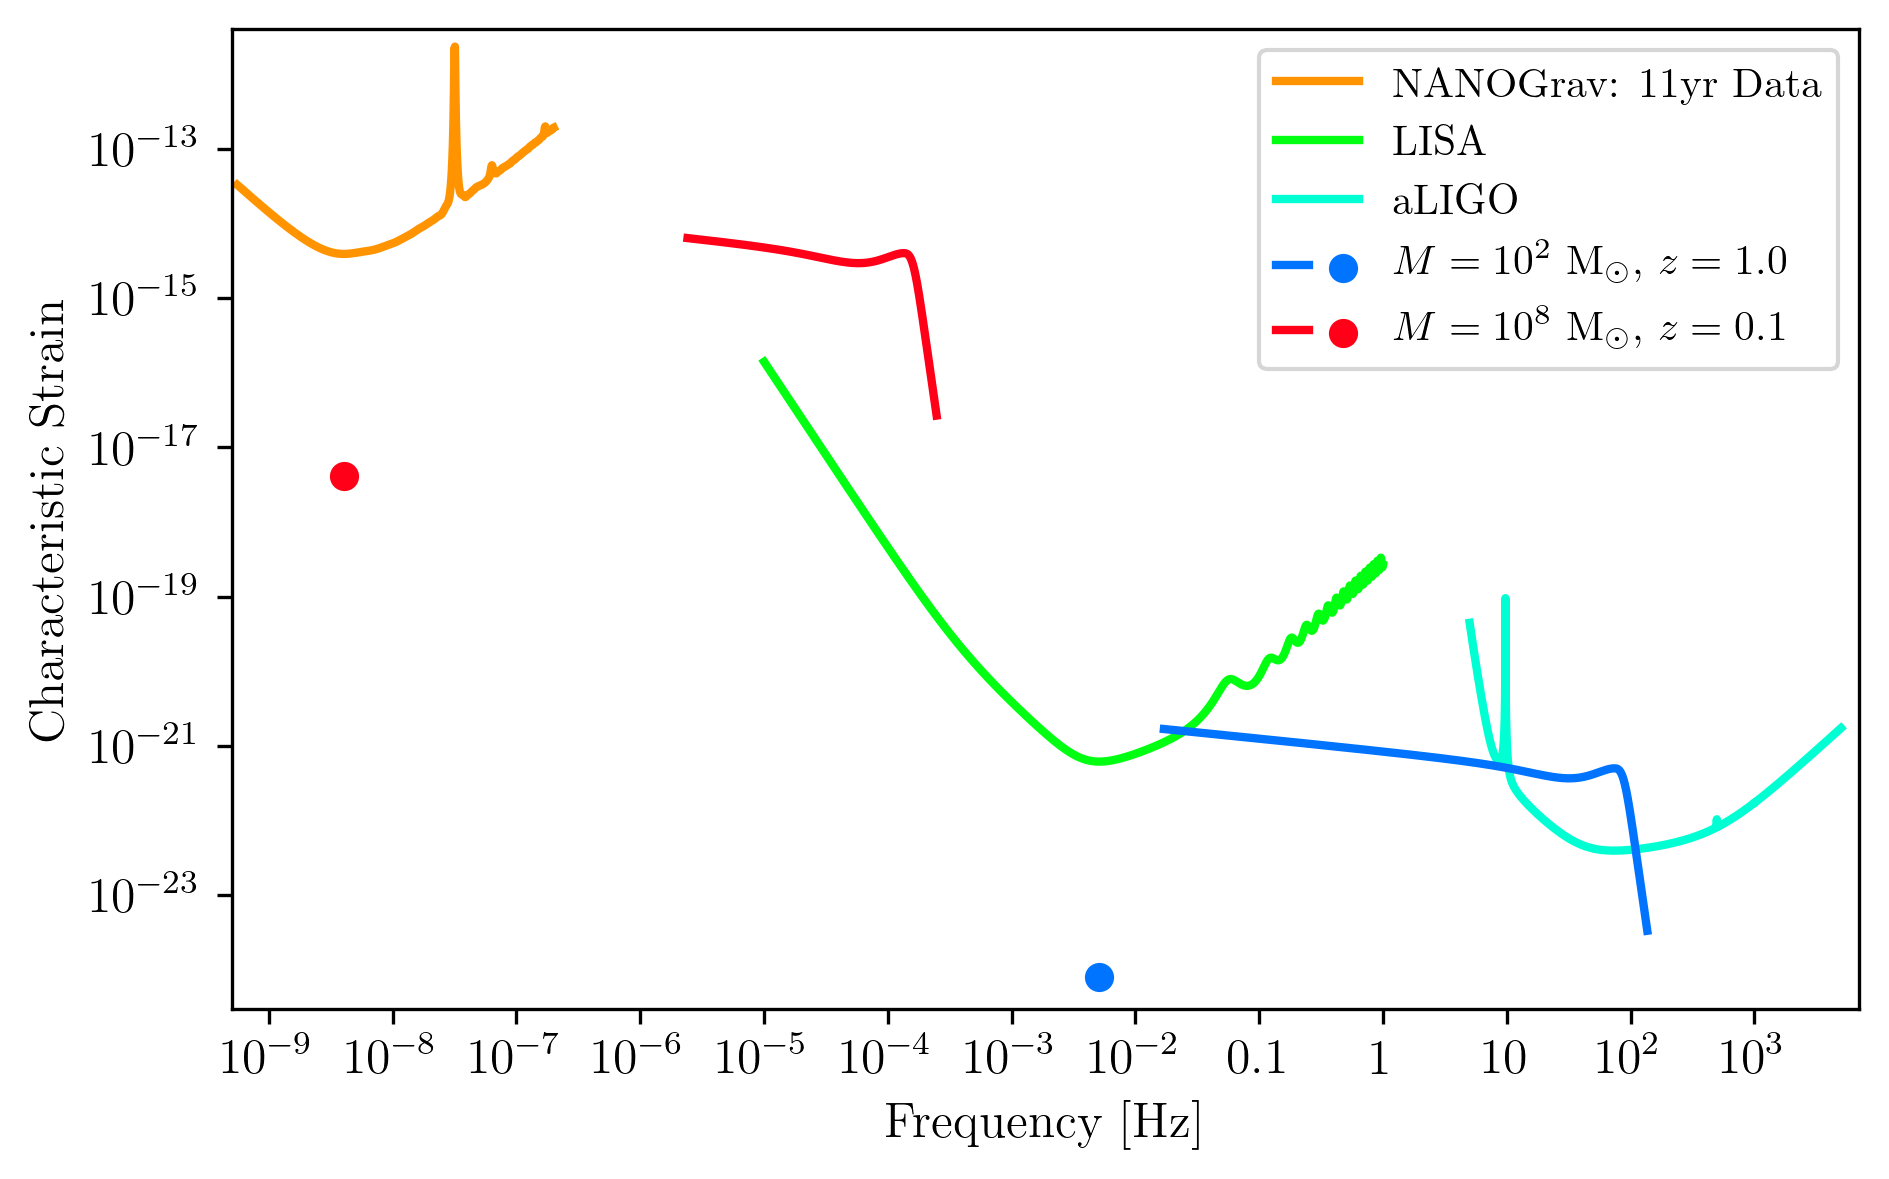

In [17]:
fig,ax = plt.subplots()

p_i_n, = ax.loglog(NANOGrav_11yr_hasasia.fT,NANOGrav_11yr_hasasia.h_n_f, color = cm.hsv(colornorm(0.5)))
p_i_l, = ax.loglog(LISA_prop1.fT,LISA_prop1.h_n_f, color = cm.hsv(colornorm(1.75)))
p_i_a, = ax.loglog(aLIGO_1.fT,aLIGO_1.h_n_f,color = cm.hsv(colornorm(2.4)))

p_s_4_l, = ax.loglog(source_4.f[idx4:],binary.Get_Char_Strain(source_4)[idx4:],color = cm.hsv(colornorm(3.0)))
p_s_4_p = ax.scatter(source_4.f_gw,binary.Get_Mono_Strain(source_4),color = cm.hsv(colornorm(3.0)))
p_s_9_l, = ax.loglog(source_5.f[idx5:],binary.Get_Char_Strain(source_5)[idx5:],color = cm.hsv(colornorm(5.0)))
p_s_9_p = ax.scatter(source_5.f_gw,binary.Get_Mono_Strain(source_5,inc=0),color = cm.hsv(colornorm(5.0)))

xlabel_min = -10
xlabel_max = 4
xlabels = np.arange(xlabel_min,xlabel_max+1)
xlabels = xlabels[1::]

ax.set_xticks(10.**xlabels)
print_xlabels = []
for x in xlabels:
    if abs(x) > 1:
        print_xlabels.append(r'$10^{%i}$' %x)
    elif x == -1:
        print_xlabels.append(r'$%.1f$' %10.**x)
    else:
        print_xlabels.append(r'$%.0f$' %10.**x)
ax.set_xticklabels([label for label in print_xlabels])

ax.set_xlim([5e-10, 7e3])
ax.set_ylim([3e-25, 4e-12])

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Characteristic Strain')
ax.legend([p_i_n,p_i_l,p_i_a,(p_s_4_l, p_s_4_p),(p_s_9_l, p_s_9_p)],
              ['NANOGrav: 11yr Data','LISA','aLIGO',
               r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$' %(np.log10(source_4.M.value),source_4.z),
               r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$' %(np.log10(source_5.M.value),source_5.z)],
              numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)},loc='upper right')
#fig.savefig(save_directory+'detector_source_overlap.png',bbox_inches='tight')
plt.show()

## Calculating the SNR
For the two sources displayed in the plot above, we will calculate the SNRs for monochromatic and chirping versions.

### Source 4: Monochromatic Case
Response in LISA data
First we set the source frequency. If you assign an instrument and not a frequency, `gwent` does this step internally and sets `f_gw` to the instruments optimal frequency (like we have done here). 

In [18]:
source_4.f_gw = LISA_prop1.f_opt
source_4.instrument = LISA_prop1
snr.Calc_Mono_SNR(source_4, LISA_prop1)

<Quantity 1.03891596 Hz(2/3) s(2/3)>

One can also change the inclination of the source for calculating the monochromatic SNR.

In [19]:
snr.Calc_Mono_SNR(source_4, LISA_prop1,inc=np.pi/2)

<Quantity 0.41066759 Hz(2/3) s(2/3)>

### Source 4: Chirping Case
Response in aLIGO data

To set the start frequency of integration, you need to set the amount of time the instrument observes the source. This is done automatically for the given instrument.

In [20]:
snr.Calc_Chirp_SNR(source_4,aLIGO_1)

10.105103404235674

### Source 5: Monochromatic Case
Response in NANOGrav: 11yr data

First we set the source frequency. This time we let `gwent` set the frequency 

In [21]:
snr.Calc_Mono_SNR(source_5, NANOGrav_11yr_hasasia)

<Quantity 0.0012629 Hz(2/3) s(2/3)>

### Source 5: Chirping Case
Response in LISA data

In [22]:
snr.Calc_Chirp_SNR(source_5,LISA_prop1)

11111.686753999282

Other ways this can be done is by setting the instrument's observation time or by using `binary.Check_Freq_Evol` and setting the optional `T_evol` parameter to the new observation time.

You can see in tis case, we have to drastically shorten the observed time to visibly change the SNR because the source waveform is so close to merger at the edge of LISA's frequency band.

In [23]:
source_5.Check_Freq_Evol(T_evol=1*u.d)
snr.Calc_Chirp_SNR(source_5,LISA_prop1)

11109.747639007504

## Generate Frequency Data from Given Time Domain

Uses waveforms that are the difference between Effective One Body waveforms subtracted from Numerical Relativity waveforms for different harmonics.

This method and use is fairly untested, so proceed with caution and feel free to help out!

In [24]:
EOBdiff_filedirectory = load_directory + '/DiffStrain/EOBdiff/'
diff0002 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0002.dat')
diff0114 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0114.dat')
diff0178 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0178.dat')
diff0261 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0261.dat')
diff0303 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0303.dat')

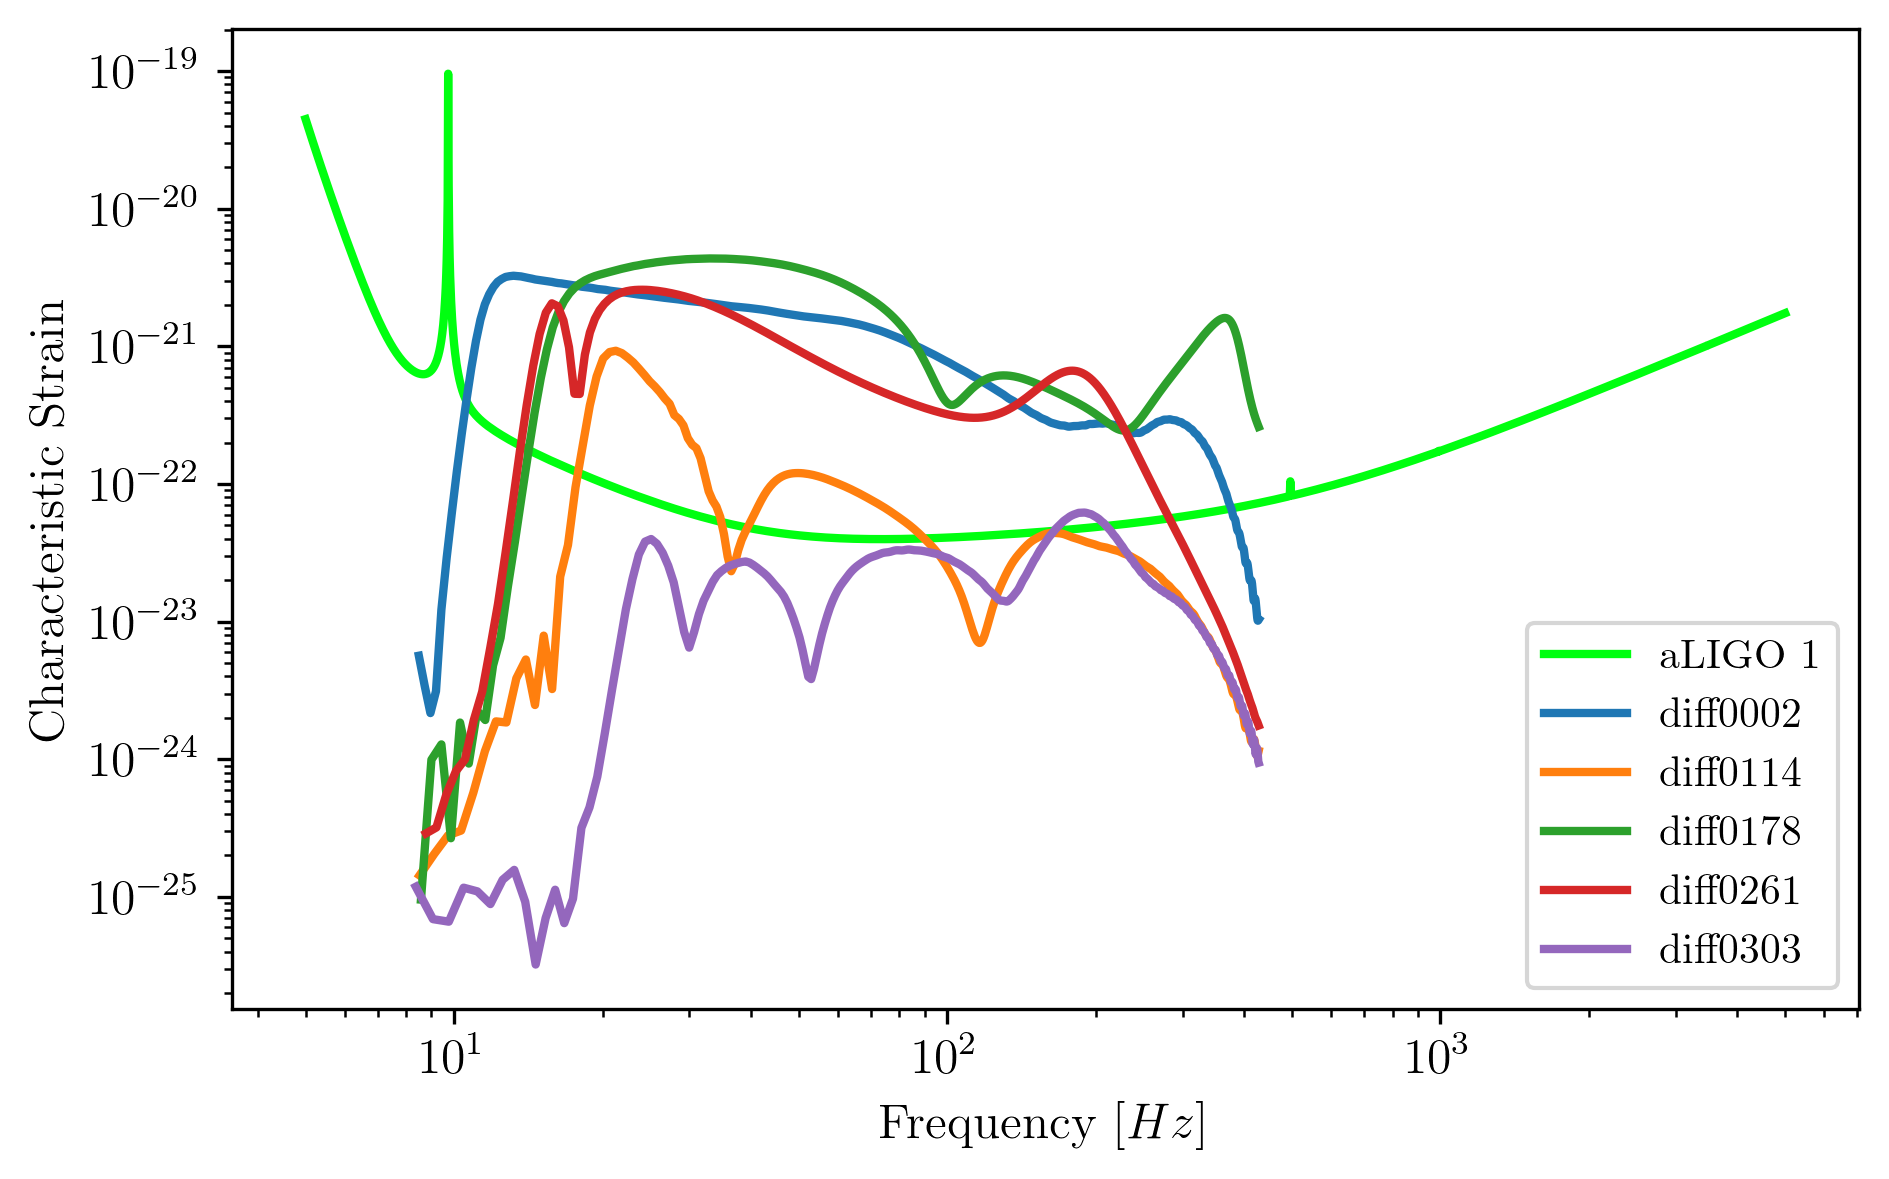

In [25]:
fig,ax = plt.subplots()
plt.loglog(aLIGO_1.fT,aLIGO_1.h_n_f,color = cm.hsv(colornorm(1.75)),label = aLIGO_1.name)
plt.loglog(diff0002.f,binary.Get_Char_Strain(diff0002),label = 'diff0002')
plt.loglog(diff0114.f,binary.Get_Char_Strain(diff0114),label = 'diff0114')
plt.loglog(diff0178.f,binary.Get_Char_Strain(diff0178),label = 'diff0178')
plt.loglog(diff0261.f,binary.Get_Char_Strain(diff0261),label = 'diff0261')
plt.loglog(diff0303.f,binary.Get_Char_Strain(diff0303),label = 'diff0303')
plt.xlabel(r'Frequency $[Hz]$')
plt.ylabel('Characteristic Strain')
plt.legend()
plt.show()